<a href="https://colab.research.google.com/github/ronniesong0809/chestX-ray/blob/master/chestX_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!echo '{"username":"ronniesong0809","key":"269788090750b1eb7d55a04d86886708"}' > kaggle.json
!cp /content/kaggle.json /root/.kaggle/kaggle.json

In [0]:
!cp /content/kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle config set -n path -v/content

- path is now set to: /content


In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:30<00:00, 21.4MB/s]
100% 2.29G/2.29G [00:31<00:00, 79.4MB/s]


In [0]:
!unzip datasets/paultimothymooney/chest-xray-pneumonia/chest-xray-pneumonia.zip

In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Softmax,Input,Flatten, SeparableConv2D
from keras.optimizers import Adam,RMSprop,SGD
from keras.layers.merge import add
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score

# from tensorflow import set_random_seed
import tensorflow as tf

Using TensorFlow backend.


In [0]:
os.environ['PYTHONHASHSEED'] = "0"
np.random.seed(1)
# set_random_seed(2)
tf.random.set_seed(2)

## Model 1: Simple CNN

In [0]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same", input_shape=(64,64,1)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(rate=0.4))
model.add(Dense(2, activation="softmax"))

## Model 2: VGG16

In [0]:
# from keras.layers import SeparableConv2D, ZeroPadding2D

# model = Sequential()
# model.add(Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1', input_shape=(224,224,1)))
# model.add(Conv2D(64, (3,3), activation="relu", padding="same"))
# # model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="SAME"))

# model.add(SeparableConv2D(128, (3,3), activation='relu', padding='same'))
# model.add(SeparableConv2D(128, (3,3), activation='relu', padding='same'))
# # model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="SAME"))

# model.add(SeparableConv2D(256, (3,3), activation='relu', padding='same'))
# model.add(SeparableConv2D(256, (3,3), activation='relu', padding='same'))
# model.add(SeparableConv2D(256, (3,3), activation='relu', padding='same'))
# # model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="SAME"))

# model.add(SeparableConv2D(512, (3,3), activation='relu', padding='same'))
# model.add(SeparableConv2D(512, (3,3), activation='relu', padding='same'))
# model.add(SeparableConv2D(512, (3,3), activation='relu', padding='same'))
# # model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="SAME"))

# model.add(SeparableConv2D(512, (3,3), activation='relu', padding='same'))
# model.add(SeparableConv2D(512, (3,3), activation='relu', padding='same'))
# model.add(SeparableConv2D(512, (3,3), activation='relu', padding='same'))
# # model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="SAME"))

# model.add(Flatten())
# model.add(Dense(4096, activation='relu'))
# model.add(Dense(4096, activation='relu'))
# # model.add(Dropout(0.7))
# model.add(Dense(1000, activation='relu'))
# # model.add(Dropout(0.5))

# model.add(Dense(2, activation='softmax'))

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)       

In [0]:
gen = ImageDataGenerator()
train_batches = gen.flow_from_directory("chest_xray/chest_xray/train", model.input_shape[1:3], color_mode="grayscale", shuffle=True, seed=1, batch_size=16)
valid_batches = gen.flow_from_directory("chest_xray/chest_xray/val",   model.input_shape[1:3], color_mode="grayscale", shuffle=True, seed=1, batch_size=16)
test_batches  = gen.flow_from_directory("chest_xray/chest_xray/test",  model.input_shape[1:3], color_mode="grayscale", shuffle=False, batch_size=8)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## **Experiment 1.** learning rate = 0.01

In [0]:
model.compile(Adam(lr=0.001),loss="categorical_crossentropy", metrics=["accuracy"])
model.fit_generator(train_batches, validation_data=valid_batches, epochs=3)

Epoch 1/3
326/326 [==============================] - 62s 190ms/step - loss: 0.2846 - accuracy: 0.9064 - val_loss: 7.3167 - val_accuracy: 0.5000
Epoch 2/3
326/326 [==============================] - 56s 173ms/step - loss: 0.1589 - accuracy: 0.9419 - val_loss: 0.5919 - val_accuracy: 0.8125
Epoch 3/3
326/326 [==============================] - 56s 173ms/step - loss: 0.1650 - accuracy: 0.9425 - val_loss: 3.4145 - val_accuracy: 0.5000


In [0]:
p = model.predict_generator(test_batches, verbose=True)
pre = pd.DataFrame(p)
pre["filename"] = test_batches.filenames
pre["label"] = (pre["filename"].str.contains("PNEUMONIA")).apply(int)
pre['pre'] = (pre[1]>0.5).apply(int)
print(pre)

78/78 [==============================] - 5s 69ms/step
                0         1                              filename  label  pre
0    6.054331e-02  0.939457              NORMAL/IM-0001-0001.jpeg      0    1
1    7.968577e-05  0.999920              NORMAL/IM-0003-0001.jpeg      0    1
2    3.420250e-04  0.999658              NORMAL/IM-0005-0001.jpeg      0    1
3    3.255044e-06  0.999997              NORMAL/IM-0006-0001.jpeg      0    1
4    1.407000e-02  0.985930              NORMAL/IM-0007-0001.jpeg      0    1
..            ...       ...                                   ...    ...  ...
619  1.351212e-09  1.000000  PNEUMONIA/person96_bacteria_465.jpeg      1    1
620  5.533320e-09  1.000000  PNEUMONIA/person96_bacteria_466.jpeg      1    1
621  3.916551e-07  1.000000  PNEUMONIA/person97_bacteria_468.jpeg      1    1
622  4.478279e-07  1.000000  PNEUMONIA/person99_bacteria_473.jpeg      1    1
623  1.595170e-05  0.999984  PNEUMONIA/person99_bacteria_474.jpeg      1    1

[624 rows

In [0]:
recall_score(pre["label"], pre["pre"])

1.0

In [0]:
roc_auc_score(pre["label"],pre[1])

0.9077690116151654

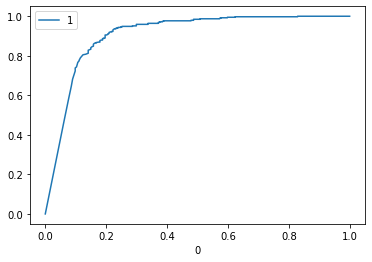

In [0]:
tpr,fpr,thres = roc_curve(pre["label"],pre[1])
roc = pd.DataFrame([tpr,fpr]).T
roc.plot(x=0,y=1)

## **Experiment 2.** learning rate = 0.001

In [0]:
model.compile(Adam(lr=0.001),loss="categorical_crossentropy", metrics=["accuracy"])
model.fit_generator(train_batches, validation_data=valid_batches, epochs=3)

Epoch 1/3
326/326 [==============================] - 57s 175ms/step - loss: 0.1735 - accuracy: 0.9419 - val_loss: 0.8525 - val_accuracy: 0.6875
Epoch 2/3
326/326 [==============================] - 56s 173ms/step - loss: 0.1396 - accuracy: 0.9500 - val_loss: 3.5784 - val_accuracy: 0.5000
Epoch 3/3
326/326 [==============================] - 56s 173ms/step - loss: 0.1221 - accuracy: 0.9548 - val_loss: 7.3646 - val_accuracy: 0.5000


In [0]:
p = model.predict_generator(test_batches, verbose=True)
pre = pd.DataFrame(p)
pre["filename"] = test_batches.filenames
pre["label"] = (pre["filename"].str.contains("PNEUMONIA")).apply(int)
pre['pre'] = (pre[1]>0.5).apply(int)
print(pre)

78/78 [==============================] - 5s 68ms/step
                0         1                              filename  label  pre
0    5.762905e-02  0.942371              NORMAL/IM-0001-0001.jpeg      0    1
1    2.646970e-04  0.999735              NORMAL/IM-0003-0001.jpeg      0    1
2    3.205183e-03  0.996795              NORMAL/IM-0005-0001.jpeg      0    1
3    3.079990e-03  0.996920              NORMAL/IM-0006-0001.jpeg      0    1
4    2.109102e-02  0.978909              NORMAL/IM-0007-0001.jpeg      0    1
..            ...       ...                                   ...    ...  ...
619  3.747863e-08  1.000000  PNEUMONIA/person96_bacteria_465.jpeg      1    1
620  8.069613e-07  0.999999  PNEUMONIA/person96_bacteria_466.jpeg      1    1
621  1.810586e-07  1.000000  PNEUMONIA/person97_bacteria_468.jpeg      1    1
622  5.615748e-05  0.999944  PNEUMONIA/person99_bacteria_473.jpeg      1    1
623  4.663210e-04  0.999534  PNEUMONIA/person99_bacteria_474.jpeg      1    1

[624 rows

In [0]:
recall_score(pre["label"], pre["pre"])

1.0

In [0]:
roc_auc_score(pre["label"],pre[1])

0.8597030462415077

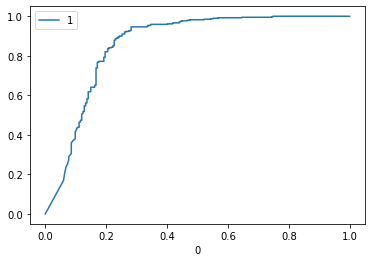

In [0]:
tpr,fpr,thres = roc_curve(pre["label"],pre[1])
roc = pd.DataFrame([tpr,fpr]).T
roc.plot(x=0,y=1)

## **Experiment 3.** learning rate = 0.0001

In [0]:
model.compile(Adam(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
model.fit_generator(train_batches, validation_data=valid_batches, epochs=3)

Epoch 1/3
326/326 [==============================] - 57s 175ms/step - loss: 0.0841 - accuracy: 0.9701 - val_loss: 0.1396 - val_accuracy: 0.8750
Epoch 2/3
326/326 [==============================] - 56s 173ms/step - loss: 0.0726 - accuracy: 0.9760 - val_loss: 0.6152 - val_accuracy: 0.7500
Epoch 3/3
326/326 [==============================] - 56s 172ms/step - loss: 0.0691 - accuracy: 0.9741 - val_loss: 0.1196 - val_accuracy: 1.0000


In [0]:
p = model.predict_generator(test_batches, verbose=True)
pre = pd.DataFrame(p)
pre["filename"] = test_batches.filenames
pre["label"] = (pre["filename"].str.contains("PNEUMONIA")).apply(int)
pre['pre'] = (pre[1]>0.5).apply(int)

78/78 [==============================] - 5s 69ms/step


In [0]:
recall_score(pre["label"],pre["pre"])

0.9897435897435898

In [0]:
roc_auc_score(pre["label"],pre[1])

0.905221345605961

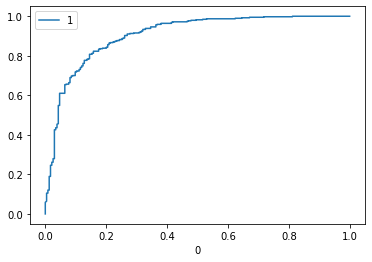

In [0]:
tpr,fpr,thres = roc_curve(pre["label"],pre[1])
roc = pd.DataFrame([tpr,fpr]).T
roc.plot(x=0,y=1)